## Correlations by session

In [9]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from scipy.spatial.distance import correlation as Dcorr
import bambi as bmb
import arviz as az
import json
import pickle 
import bammm.bammm as mm
from scipy.stats import zscore as zscore_sc


# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
#sys.path.insert(1, os.path.join(root_dir, "covid-fear", "scripts", "lib", "hoeffding"))


##### VERY IMPORTANT ####

df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

tdf = df.loc[df["sess_str"]=="sess0",:]
tdf = tdf.loc[:,["PROLIFICID", "q7_worry_infected", "q8_prob_inf_me" ]]
tdf = tdf.rename(columns={"q7_worry_infected": "worry_infected_sess1", 
                          "q8_prob_inf_me": "prob_infected_sess1"  }).set_index("PROLIFICID")
tdf = tdf.loc[df.loc[df["sess_str"]=="sess19","PROLIFICID"],:]


#df = df.set_index("PROLIFICID")
#df = df.join(tdf, how="left")
#df2.prob_infectes_sess1
##df["memory_worry_infected_baselined"] = df["q7_worry_infected"] - df["worry_infected_sess1"]
#df["memory_prob_infected_baselined"] = df["q8_prob_inf_me"] - df["prob_infected_sess1"]

##### VERY IMPORTANT ####

mapdict = {'TF3_NegativeAffect': 'TF3',
           'TF2_PhysiolAnx': 'TF2', 
           'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'ProbabilityEstims',
           'q7_worry_econ_impact': 'EconWorry',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGroup',
           'avoid_beh': 'AvoidBeh',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaValence',
           'q7_period_rel_danger': 'CurrentThreat',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'q6_houshold_membs': "HouseholdMembers",
           'sticsa_som_sa_currsess': "StateSomAnx",
       #    "q6_close_person_infdied": "ClosePDied",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 

            #"affheallth-econ-worry": "Health>Econ \n worry", 
            #"covid_cases_est_diff": "Estimate of \n covid cases"
           }

df=df.rename(columns=mapdict)

# Create column with appropriate dates
df["Session"] = df["session"] + 1
df["date"] = pd.to_datetime( df["submitdate"]).dt.strftime("%B '%y")
months = df.groupby(by="Session")["date"].apply(lambda x: np.array(x.reset_index().iloc[0,1])).reset_index()
months["session"] = months["Session"]-1

## transform and generate some variables (to be moved to preprocessing)

vars = [
        # core things interested in 
        "Deaths",
        "Cases",
        "CurrentThreat",
        "ProbabilityEstims",
        "InforSeek",
        "AvoidBeh",
        "Worry"
        ]

# Zscore
#for c in vars: 
#    df[c] = df.groupby(by="Session")[c].apply(zscore_sc, nan_policy="omit")






/data/drive/postdoc/Project4_covid


In [10]:
### Meta parameters
corr_type = "spearman" # used in all analyses

no_covid_factors = 3
if no_covid_factors ==6:
    factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
elif no_covid_factors==3:
    factors = ["F1_CovidAnxietyWorry", "F2_CovidProbabilityEsts", "F3_Economic"]
    
#print("State seveirty NaNs: "+str(df["state_severity"].isna().sum())+" out of entries: "+ str(df.shape[0]))

no_trait_factors = 3
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF1_CognAnxDepr",  "TF2_PhysiolAnx","TF3_NegativeAffect" ]
        tfs = ["TF"+str(x) for x in range(1,4)]
elif no_trait_factors==2:
        trait_factor_names = ["TF2_PhysiolAnx", "TF1_CognAnxDepr"]
elif no_trait_factors==44:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr","stai_ta"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 




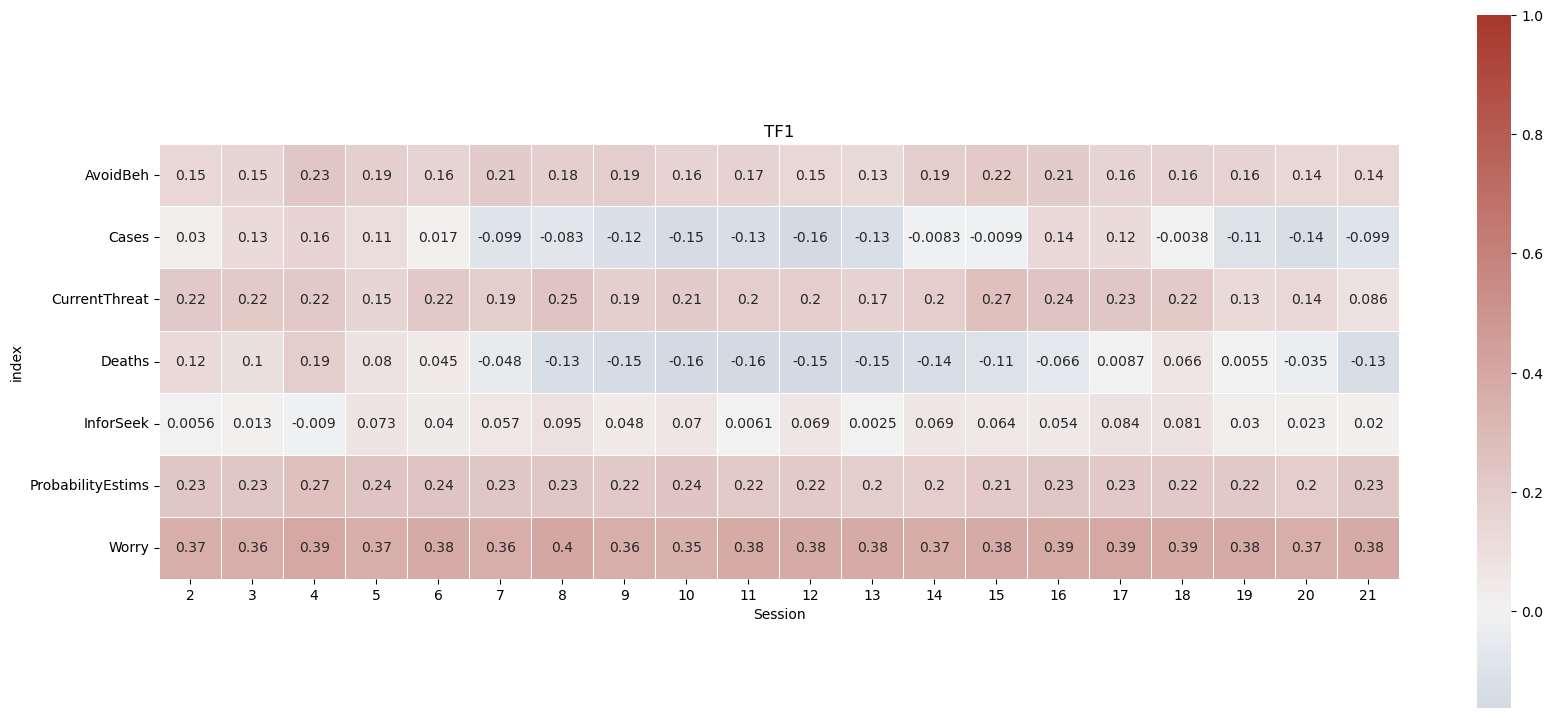

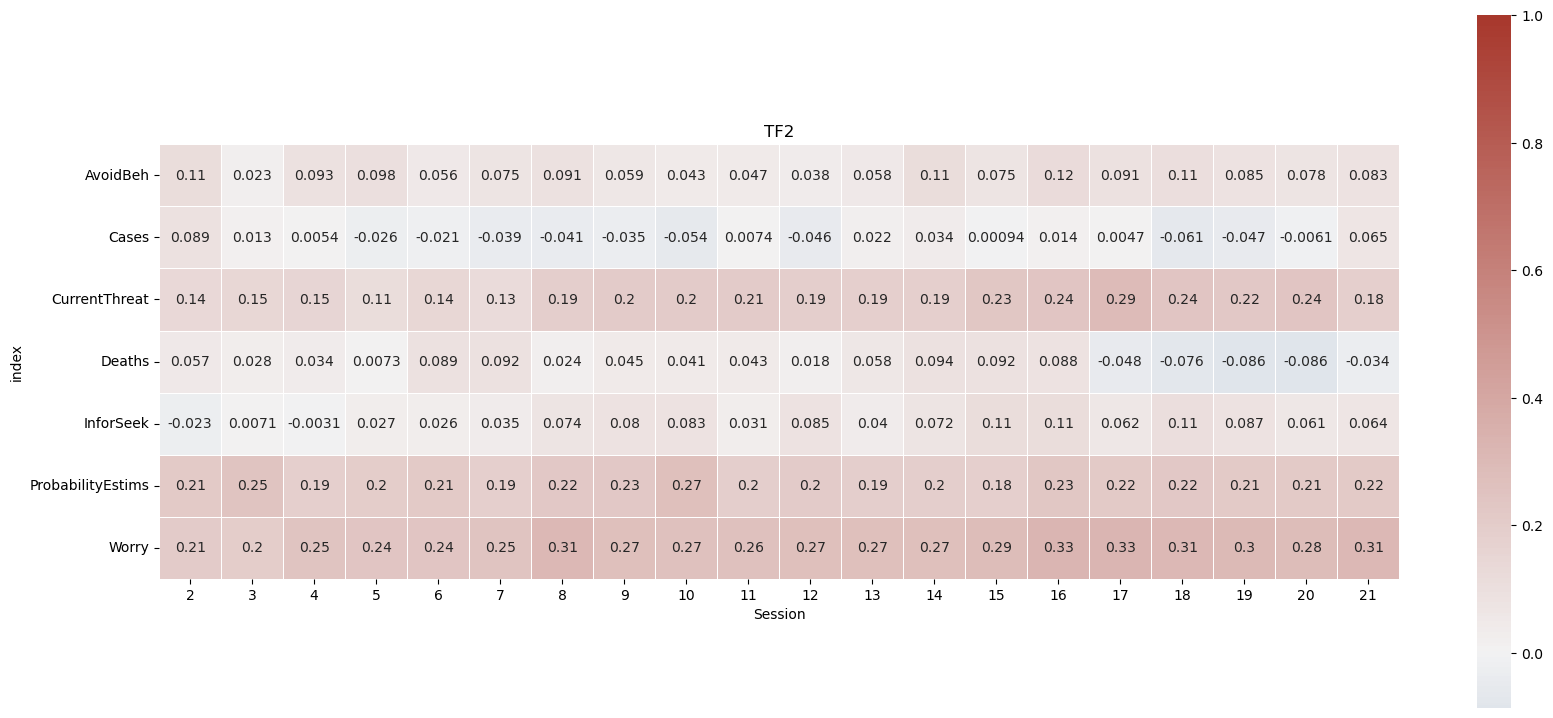

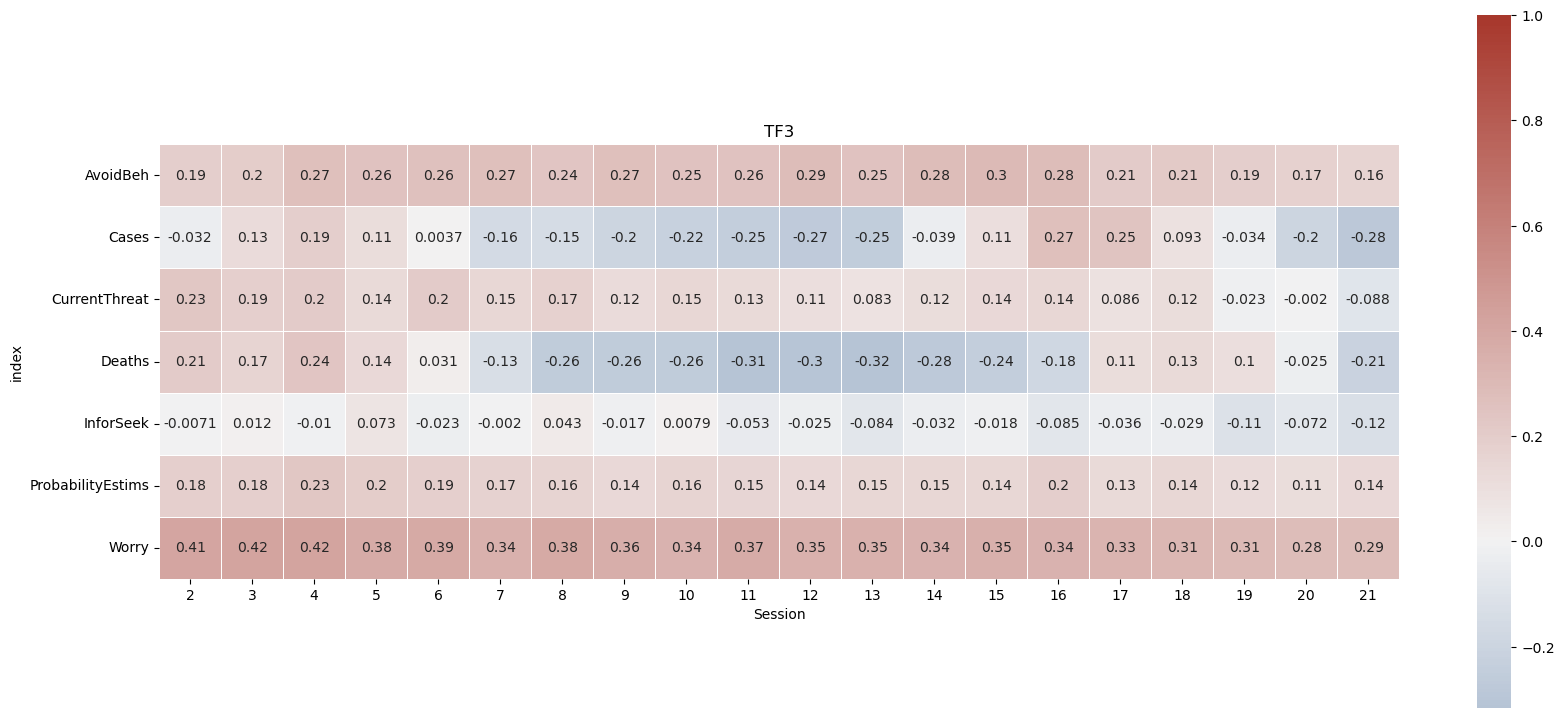

In [11]:

cordf = pd.DataFrame()
for s in df["Session"].unique():
    

    data = df.loc[df["Session"]==s,vars+tfs] # df.groupby(by="PROLIFICID")[["PROLIFICID", "state_severity"]+vars].mean()

    #for f in factors:
    #    data["r_"+f] = np.nan
    #    # append to vars
    #    vars = vars+["r_"+f]
    #    for s in df["PROLIFICID"].unique():
    #        data["r_"+f][s] = df.loc[df["PROLIFICID"].isin([s])][["state_severity",   f]].corr(corr_type).loc["state_severity"][f]

    #print("State seveirty NaNs: "+str(data["state_severity"].isna().sum())+" out of entries: "+ str(data.shape[0]))

    # calculate correlation matrix
    corr = data.corr(corr_type)
    #print(corr)
    corr2 = corr.loc[tfs, ~corr.index.isin(tfs)].T.reset_index()
    corr2["Session"] = s
    cordf = pd.concat([cordf, corr2])
    # Generate a mask for the upper triangle
    #mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    #f, ax = plt.subplots(figsize=(35, 24))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(250, 15, s=75, l=40,
    #                            n=9, center="light", 
    #                            as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    #sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
    #            square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})

    #data.to_csv(os.path.join(root_dir, "data", "summarized_data_for_secondary_factor_analysis.csv"))
for t in tfs:

    td = cordf.loc[:,["index", "Session", t]]
    td = td.pivot(index="index", columns="Session", values=t )
    #mask = np.triu(np.ones_like(td, dtype=bool))
    f, ax = plt.subplots(figsize=(20, 18))
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                    n=9, center="light", 
                                    as_cmap=True)
    ax = sns.heatmap(td, cmap=cmap, vmax=1, center=0,
                    square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title(t)


In [12]:
data = df.groupby(by=[x+"_ms" for x in trait_factor_names] + ["PROLIFICID", "Session"])[["PROLIFICID"]+vars].mean().reset_index()
tdata = data.melt(id_vars=vars+["Session"], value_vars=[x+"_ms" for x in trait_factor_names], var_name="traitf", value_name="level" )

#trait_factor_names =trait_factor_names+ [x+"_ms" for x in trait_factor_names]
    

In [13]:
colist= [[  "navy", "dodgerblue"], ["crimson", "lightcoral"], ["xkcd:dark sea green", "xkcd:pale teal"]]
# checked for color blindness

[colist[x][0] for x in range(3)]

['navy', 'crimson', 'xkcd:dark sea green']

Deaths
Cases
CurrentThreat
ProbabilityEstims
InforSeek
AvoidBeh
Worry


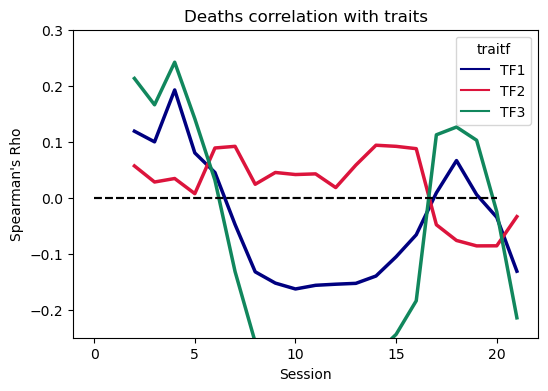

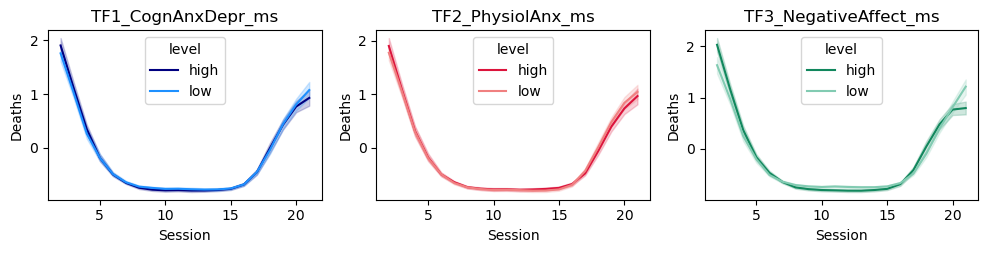

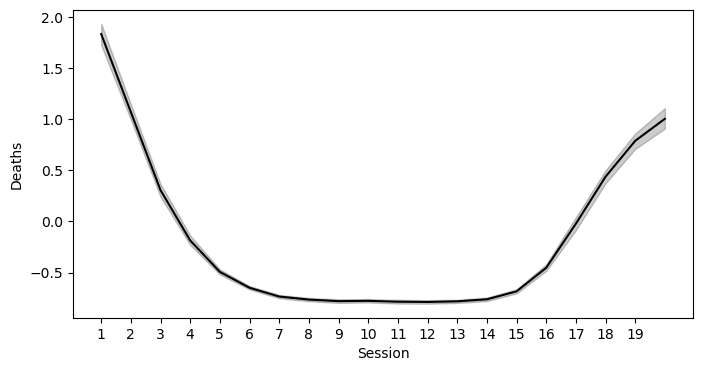

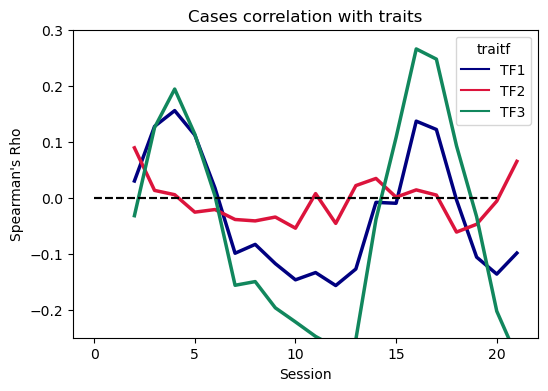

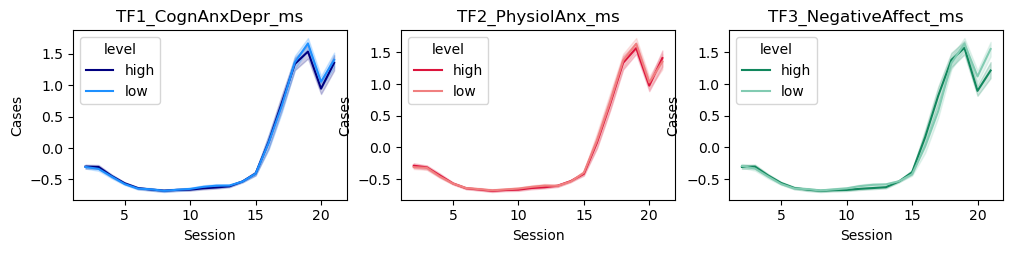

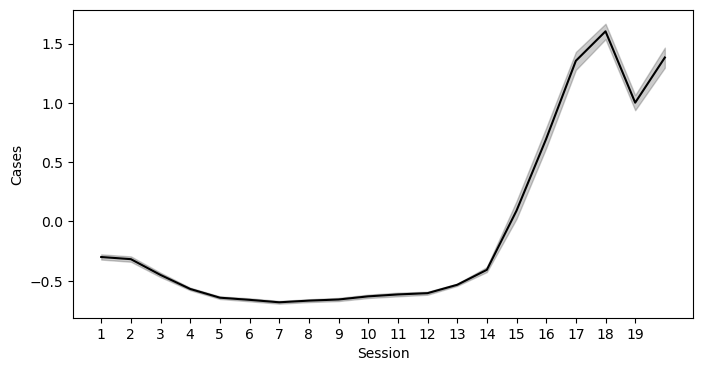

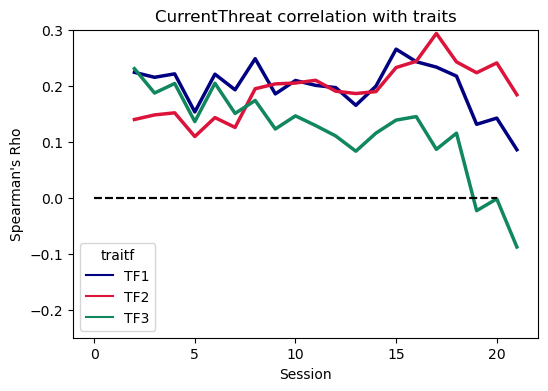

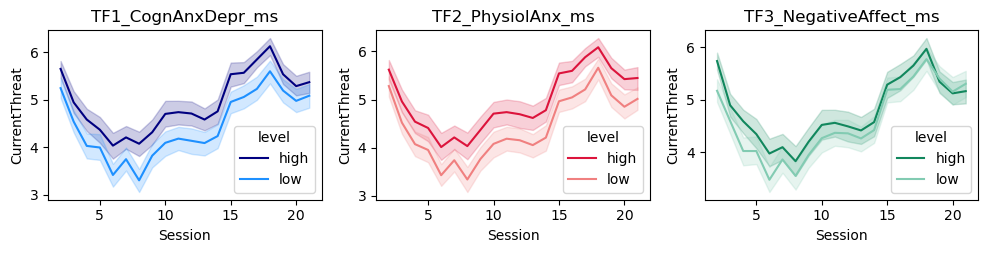

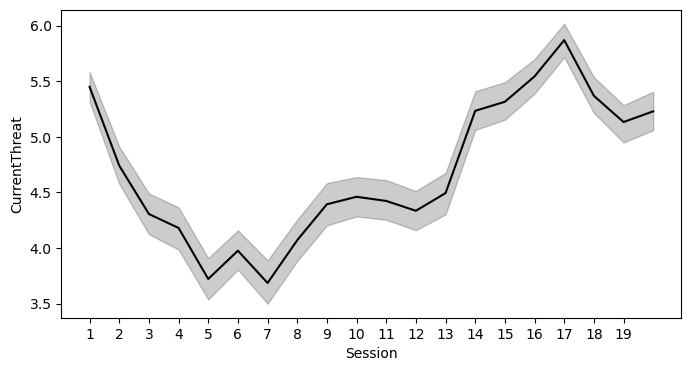

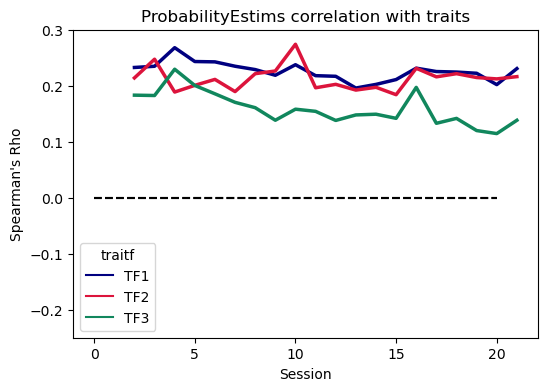

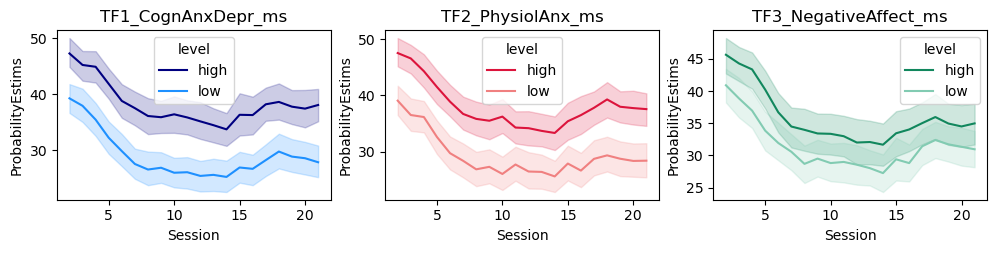

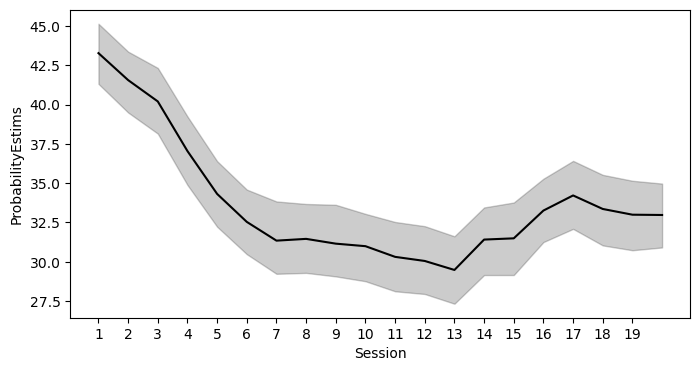

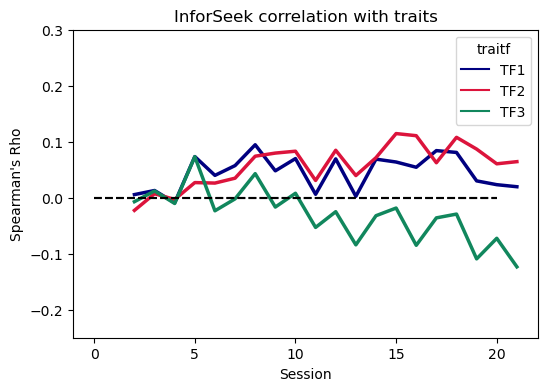

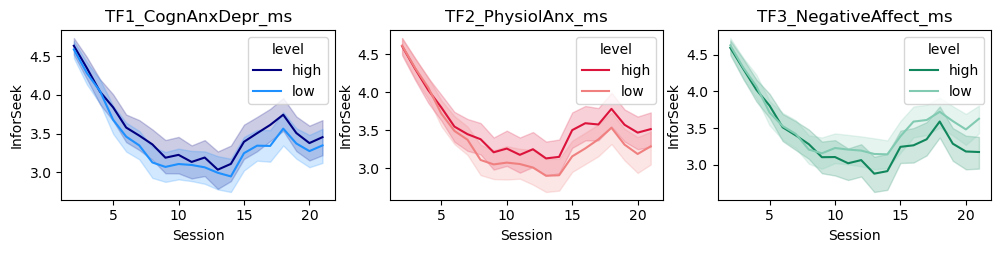

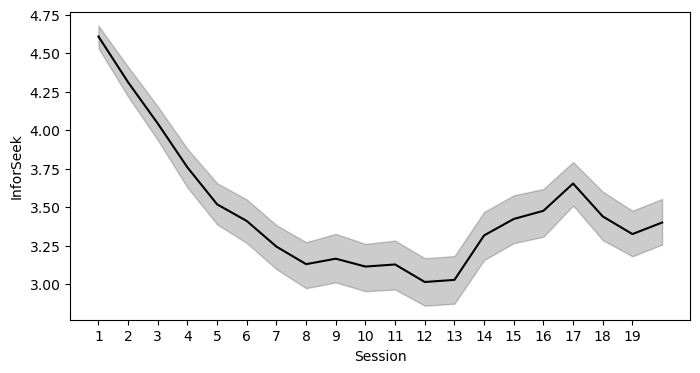

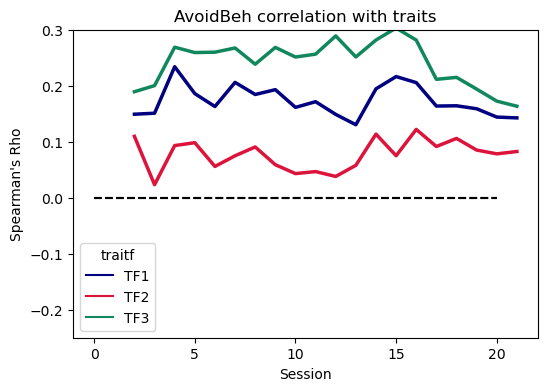

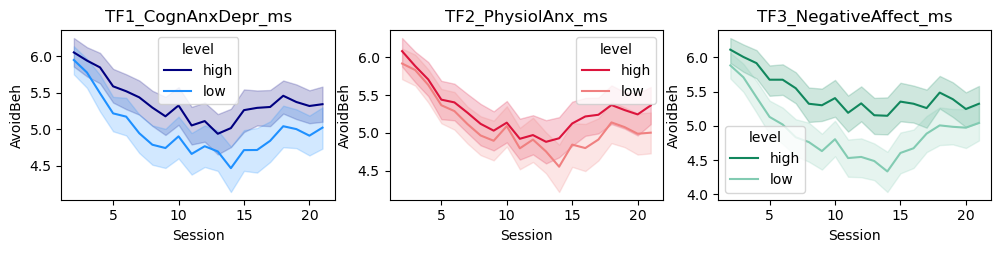

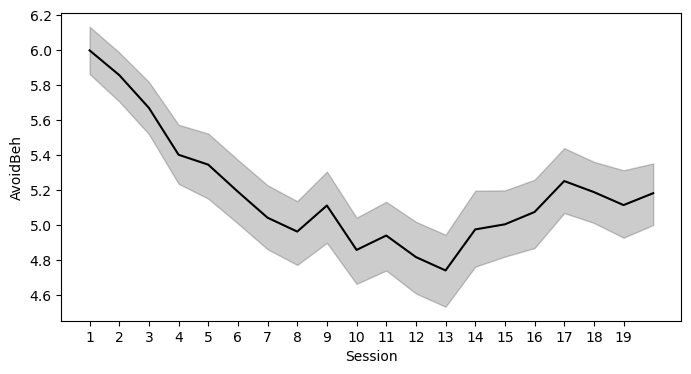

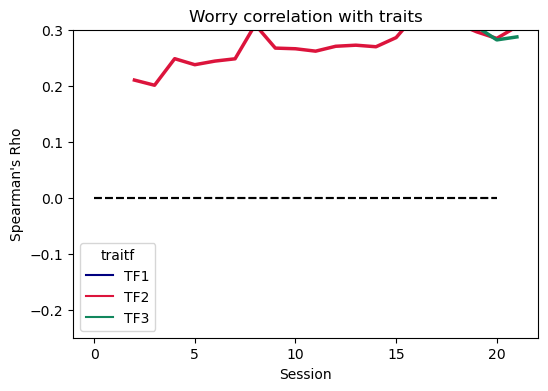

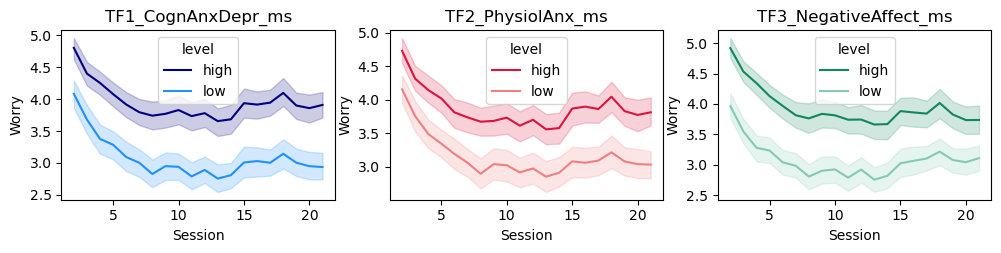

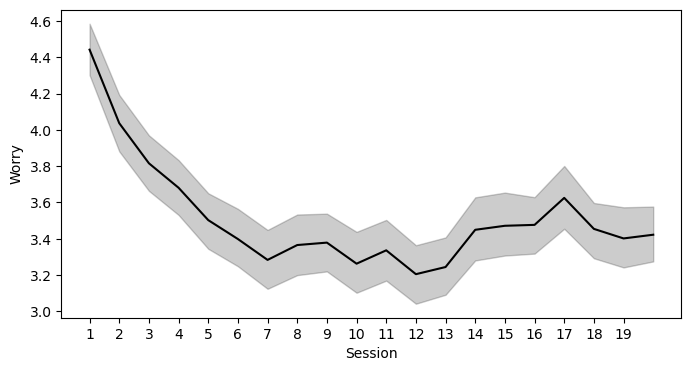

In [14]:
cordf
for v in cordf["index"].unique():
    print(v)
    td = cordf.loc[cordf["index"].isin([v]),:]
    td = td.melt(id_vars="Session", value_vars=tfs, var_name="traitf", value_name="corr" )

    f, ax = plt.subplots(1,1,figsize=(6,4))
    ax=sns.lineplot(data=td, x="Session", y="corr", hue="traitf", ax=ax, linewidth=2.5, palette=[colist[x][0] for x in range(3)])
    ax.set_title(v+ " correlation with traits")
    ax.set_ylabel("Spearman's Rho")

    ax.set_ylim([-0.25, 0.3])
    ax.hlines( [0, 0], 0, 20,linestyles='dashed', colors=['black'])

    f, ax = plt.subplots(1,len(tfs),figsize=(12,2.2))
    f.subplots_adjust(hspace=0.65)
    for t_idx, t in enumerate([x+"_ms" for x in trait_factor_names]): 
        tdf = tdata.loc[tdata["traitf"].isin([t]),:]
        axx=sns.lineplot(data=tdf, x="Session", y=v, hue="level", ax=ax[t_idx], palette=colist[t_idx])
        axx.set_title(t)

    plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs',  'PUG_2024', v+'.pdf'), dpi=300, quality=80, optimize=True, progressive=True)  

    
    f,ax = plt.subplots(1,1, figsize=(8,4))
    ax = sns.lineplot(data=df, x="Session", y=v, ax=ax, legend=True, color= "black")
    ax.set_xticks(np.arange(2,21))
    ax.set_xticklabels(np.arange(1,20))    


### Generat figure for paper

In [15]:
invars = ['CurrentThreat',
 'ProbabilityEstims',
 'Worry',
 'AvoidBeh',
 'InforSeek'
 ]


In [16]:
import numpy as np
import pandas as pd
import pingouin as pg

# Initialize an empty DataFrame to store results
cordf = pd.DataFrame()

# Loop through each session
for s in df["session"].unique():
    data = df.loc[df["session"] == s, vars + tfs]

    for var in vars:
        for tf in tfs:
            # Calculate Spearman correlation and 95% CI using pingouin
            corr_result = pg.corr(data[var], data[tf], method='spearman')

            # Extract the correlation and confidence intervals
            corr = corr_result['r'].values[0]
            ci_lower = corr_result['CI95%'][0][0]
            ci_upper = corr_result['CI95%'][0][1]

            # Append results to cordf
            cordf = cordf.append({
                "Session": s,
                "Variable1": var,
                "Variable2": tf,
                "SpearmanCorrelation": corr,
                "CI_lower": ci_lower,
                "CI_upper": ci_upper
            }, ignore_index=True)

# Reset the index of the final DataFrame
cordf.reset_index(drop=True, inplace=True)

cordf["Session"].unique()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

CurrentThreat
ProbabilityEstims
Worry
AvoidBeh
InforSeek


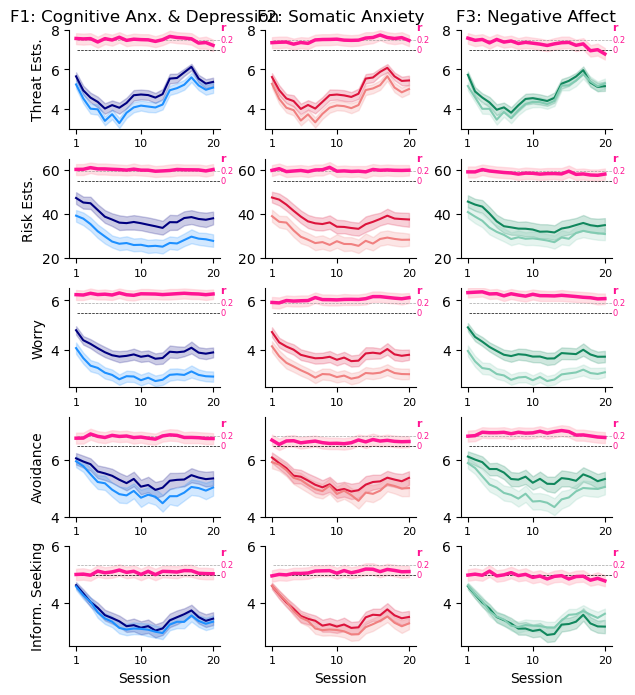

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(len(invars), 3, figsize=(7, 8))
titles = ["F1: Cognitive Anx. & Depression", "F2: Somatic Anxiety", "F3: Negative Affect"]
newnames = ["Threat Ests.", "Risk Ests.", "Worry", "Avoidance", "Inform. Seeking"]

yy = {
    "CurrentThreat": [3, 8],
    "ProbabilityEstims": [20, 65], 
    "Worry": [2.5, 6.5], 
    "AvoidBeh": [4, 7.5], 
    "InforSeek": [2.5, 6]
}

ly = {
    "CurrentThreat": 7,
    "ProbabilityEstims": 55, 
    "Worry": 5.5, 
    "AvoidBeh": 6.5, 
    "InforSeek": 5
}

corr_scale = 0.5

for vidx, v in enumerate(invars):
    print(v)
    td = cordf.loc[cordf["Variable1"] == v]

    for t_idx, t in enumerate([x + "_ms" for x in trait_factor_names]): 
        tdf = tdata.loc[tdata["traitf"].isin([t]), :]
        axx = sns.lineplot(data=tdf, x="Session", y=v, hue="level", ax=ax[vidx, t_idx], palette=colist[t_idx])
        
        # Remove the legend
        axx.get_legend().remove()

        # Set y-limits
        axx.set_ylim(yy[v])

        # Set x-ticks at 2, 11, and 21 (but display as 1, 10, 20)
        axx.set_xticks([2, 11, 21])
        axx.set_xticklabels([1, 10, 20], fontsize=8)

        # Title only for the top row
        if vidx == 0:
            axx.set_title(titles[t_idx])

        # Y-label only for the first column
        if t_idx == 0:
            axx.set_ylabel(newnames[vidx])
        else:
            axx.set_ylabel("")

        # X-label only for the bottom row
        if vidx == len(invars) - 1:
            axx.set_xlabel("Session")
        else:
            axx.set_xlabel("")

        # Remove top and right spines
        axx.spines['top'].set_visible(False)
        axx.spines['right'].set_visible(False)

        # Plot the horizontal dashed line at the computed y-value (r = 0)
        axx.axhline(ly[v], xmin=0.05, color='black', linestyle='--', linewidth=0.5, label='0')

        # Plot the faint gray line at r = 0.2
        r02_y = ly[v] + 0.2 * corr_scale * (yy[v][1] - yy[v][0])
        axx.axhline(r02_y, xmin=0.05, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

        # Plot the correlation line and 95% CI
        corr_data = td.loc[td["Variable2"] == "TF"+str(t_idx+1),]
        y_range = yy[v][1] - yy[v][0]
        scaled_corr = corr_data["SpearmanCorrelation"] * corr_scale * y_range

        axx.fill_between(corr_data["Session"]+1, ly[v] + corr_data["CI_lower"] * corr_scale * y_range, ly[v] + corr_data["CI_upper"] * corr_scale * y_range, color='pink', alpha=0.5)
        axx.plot(corr_data["Session"]+1, ly[v] + scaled_corr, color='deeppink', linewidth=1.5)

        # Add labels next to the r = 0 and r = 0.2 lines
        axx.text(22.02, ly[v], "0", color="deeppink", fontsize=6, verticalalignment='center')
        axx.text(22.02, r02_y, "0.2", color="deeppink", fontsize=6, verticalalignment='center')
        lbl_y =  ly[v] + 0.45 * corr_scale * (yy[v][1] - yy[v][0])
        axx.text(22.02, lbl_y, "r", color="deeppink", fontsize=8, verticalalignment='center',weight='bold')

# Adjust the space between subplots
f.subplots_adjust(hspace=0.3, wspace=0.3)

# Save the figure with adjustments
plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs', 'paper_figures', 'timecourses_by_traits', 'raw_fig.pdf'), dpi=300, quality=80, optimize=True, progressive=True)


CurrentThreat
ProbabilityEstims
Worry
AvoidBeh
InforSeek


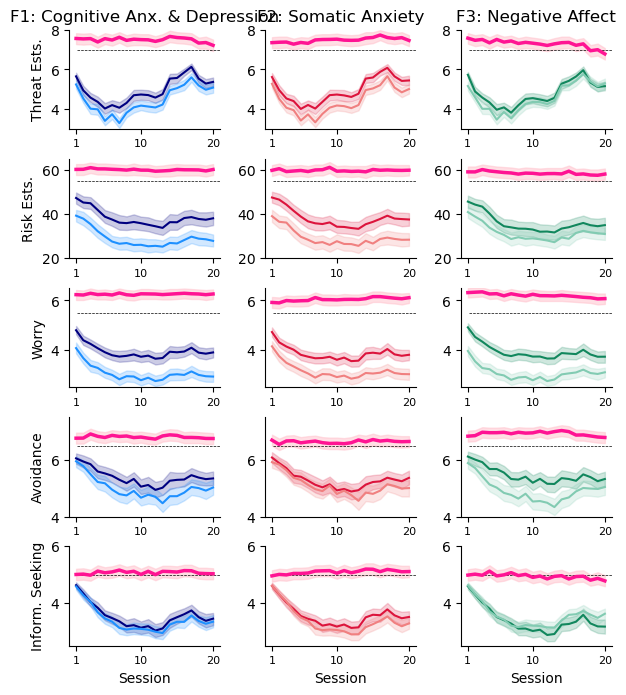

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(len(invars), 3, figsize=(7, 8))
titles = ["F1: Cognitive Anx. & Depression", "F2: Somatic Anxiety", "F3: Negative Affect"]
newnames = ["Threat Ests.", "Risk Ests.", "Worry", "Avoidance", "Inform. Seeking"]

yy = {
    "CurrentThreat": [3, 8],
    "ProbabilityEstims": [20, 65], 
    "Worry": [2.5, 6.5], 
    "AvoidBeh": [4, 7.5], 
    "InforSeek": [2.5, 6]
}

ly = {
    "CurrentThreat": 7,
    "ProbabilityEstims": 55, 
    "Worry": 5.5, 
    "AvoidBeh": 6.5, 
    "InforSeek": 5
}

corr_scale = 0.5

for vidx, v in enumerate(invars):
    print(v)
    td = cordf.loc[cordf["Variable1"] == v]

    for t_idx, t in enumerate([x + "_ms" for x in trait_factor_names]): 
        tdf = tdata.loc[tdata["traitf"].isin([t]), :]
        axx = sns.lineplot(data=tdf, x="Session", y=v, hue="level", ax=ax[vidx, t_idx], palette=colist[t_idx])
        
        # Remove the legend
        axx.get_legend().remove()

        # Set y-limits
        axx.set_ylim(yy[v])

        # Set x-ticks at 2, 11, and 21 (but display as 1, 10, 20)
        axx.set_xticks([2, 11, 21])
        axx.set_xticklabels([1, 10, 20], fontsize=8)

        # Title only for the top row
        if vidx == 0:
            axx.set_title(titles[t_idx])

        # Y-label only for the first column
        if t_idx == 0:
            axx.set_ylabel(newnames[vidx])
        else:
            axx.set_ylabel("")

        # X-label only for the bottom row
        if vidx == len(invars) - 1:
            axx.set_xlabel("Session")
        else:
            axx.set_xlabel("")

        # Remove top and right spines
        axx.spines['top'].set_visible(False)
        axx.spines['right'].set_visible(False)

        # Plot the horizontal dashed line at the computed y-value
        axx.axhline(ly[v], xmin=0.05, color='black', linestyle='--', linewidth=0.5, label='0')

        # Plot the correlation line and 95% CI
        corr_data = td.loc[td["Variable2"] == "TF"+str(t_idx+1),]
        y_range = yy[v][1] - yy[v][0]
        scaled_corr = corr_data["SpearmanCorrelation"] * corr_scale * y_range


        axx.fill_between(corr_data["Session"]+1, ly[v] +  corr_data["CI_lower"] * corr_scale * y_range, ly[v] +  corr_data["CI_upper"] * corr_scale * y_range, color='pink', alpha=0.5)
        axx.plot(corr_data["Session"]+1, ly[v] + scaled_corr, color='deeppink', linewidth=2.5)

        

# Adjust the space between subplots
f.subplots_adjust(hspace=0.3, wspace=0.3)

# Save the figure with adjustments
plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs', 'paper_figures', 'timecourses_by_traits', 'raw_fig.pdf'), dpi=300, quality=80, optimize=True, progressive=True)


CurrentThreat
ProbabilityEstims
Worry
AvoidBeh
InforSeek


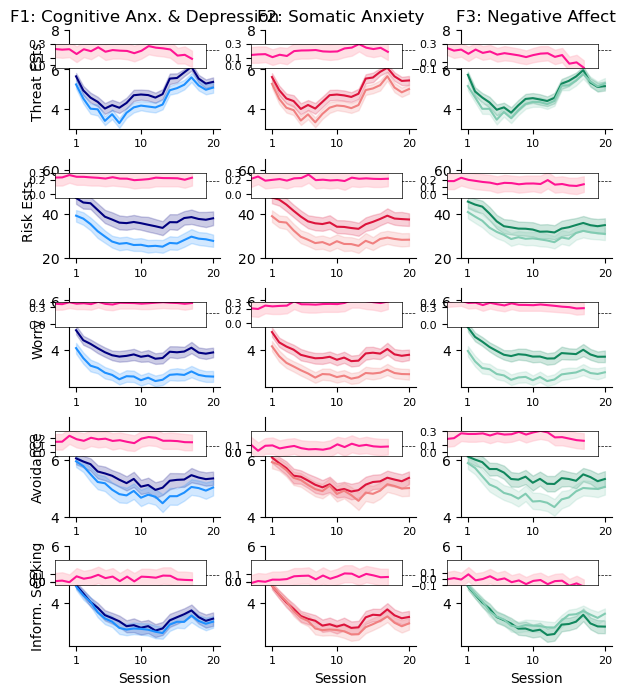

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

f, ax = plt.subplots(len(invars), 3, figsize=(7, 8))
titles = ["F1: Cognitive Anx. & Depression", "F2: Somatic Anxiety", "F3: Negative Affect"]
newnames = ["Threat Ests.", "Risk Ests.", "Worry", "Avoidance", "Inform. Seeking"]

yy = {
    "CurrentThreat": [3, 8],
    "ProbabilityEstims": [20, 65], 
    "Worry": [2.5, 6.5], 
    "AvoidBeh": [4, 7.5], 
    "InforSeek": [2.5, 6]
}

ly = {
    "CurrentThreat": 7,
    "ProbabilityEstims": 55, 
    "Worry": 5.5, 
    "AvoidBeh": 6.5, 
    "InforSeek": 5
}

corr_scale = 0.5

for vidx, v in enumerate(invars):
    print(v)
    td = cordf.loc[cordf["Variable1"] == v]

    for t_idx, t in enumerate([x + "_ms" for x in trait_factor_names]): 
        tdf = tdata.loc[tdata["traitf"].isin([t]), :]
        axx = sns.lineplot(data=tdf, x="Session", y=v, hue="level", ax=ax[vidx, t_idx], palette=colist[t_idx])
        
        # Remove the legend
        axx.get_legend().remove()

        # Set y-limits
        axx.set_ylim(yy[v])

        # Set x-ticks at 2, 11, and 21 (but display as 1, 10, 20)
        axx.set_xticks([2, 11, 21])
        axx.set_xticklabels([1, 10, 20], fontsize=8)

        # Title only for the top row
        if vidx == 0:
            axx.set_title(titles[t_idx])

        # Y-label only for the first column
        if t_idx == 0:
            axx.set_ylabel(newnames[vidx])
        else:
            axx.set_ylabel("")

        # X-label only for the bottom row
        if vidx == len(invars) - 1:
            axx.set_xlabel("Session")
        else:
            axx.set_xlabel("")

        # Remove top and right spines
        axx.spines['top'].set_visible(False)
        axx.spines['right'].set_visible(False)

        # Plot the horizontal dashed line at the computed y-value
        axx.axhline(ly[v], color='black', linestyle='--', linewidth=0.5, label='0')

        # Create an inset axes for the correlation plot
        ax_inset = inset_axes(axx, width="100%", height="25%", loc='upper right', borderpad=1)
        ax_inset.set_xlim(axx.get_xlim())  # Align x-axis with the main plot

        # Calculate dynamic y-limits for the correlation plot
        corr_data = td.loc[td["Variable2"] == "TF"+str(t_idx+1),]
        corr_min = corr_data["SpearmanCorrelation"].min()
        corr_max = corr_data["SpearmanCorrelation"].max()
        corr_range = corr_max - corr_min
        ymin = corr_min - corr_range * 0.1
        ymax = corr_max + corr_range * 0.1

        # Adjust ymin and ymax to be multiples of 0.1
        ymin = round(ymin * 10) / 10
        ymax = round(ymax * 10) / 10

        ax_inset.set_ylim([-0.05, 0.3])
        ax_inset.set_yticks([ymin, 0, ymax])
        ax_inset.tick_params(axis='y', labelsize=8)

        # Plot the correlation line and 95% CI in the inset plot
        ax_inset.fill_between(corr_data["Session"], corr_data["CI_lower"], corr_data["CI_upper"], color='pink', alpha=0.5)
        ax_inset.plot(corr_data["Session"], corr_data["SpearmanCorrelation"], color='deeppink', linewidth=1.5)

        # Add a solid bounding box around the inset plot
        for spine in ax_inset.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(0.5)

        # Remove x-axis labels for the inset (because it shares with the main plot)
        ax_inset.set_xticks([])

        # Move y-axis for inset plot to the left
        ax_inset.yaxis.set_ticks_position('left')
        ax_inset.yaxis.set_label_position('left')

# Adjust the space between subplots
f.subplots_adjust(hspace=0.3, wspace=0.3)

# Save the figure with adjustments
output_dir = os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs', 'paper_figures', 'timecourses_by_traits')
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
plt.savefig(os.path.join(output_dir, 'raw_fig.pdf'), dpi=300, quality=80, optimize=True, progressive=True, bbox_inches='tight')


### Correlation of perception of dnager and deaths/cases

In [7]:
df["date"] = pd.to_datetime( df["submitdate"]).dt.strftime("%B '%y")
months = df.groupby(by="session")["date"].apply(lambda x: np.array(x.reset_index().iloc[0,1])).reset_index()
months["sessiontrue"] = months["session"] + 1
months["sessmonth_str"] = "S" + months["sessiontrue"].astype(str) + " (" + months["date"].astype(str) + ")"
pd.merge(df, months.loc[:,["sessmonth_str", "session"]], on='session')

PROLIFICID      PROLIFICID.1 GROUP  session  index  \
0     01S0stEpc3rU6YxK  01S0stEpc3rU6YxK    UK        1    217   
1     05c9AaLx1V20UAcO  05c9AaLx1V20UAcO    BE        1     82   
2     07GDvN1Nh0oHcEBM  07GDvN1Nh0oHcEBM    UK        1      4   
3     0OjnLzK5ABd2wO54  0OjnLzK5ABd2wO54    BE        1     11   
4     0Pe1blVigsBRLvBj  0Pe1blVigsBRLvBj    UK        1     47   
...                ...               ...   ...      ...    ...   
5820  zNbLeZqHa6wNHRLR  zNbLeZqHa6wNHRLR    UK       20   4937   
5821  zYWr4nlB9BwdVWFB  zYWr4nlB9BwdVWFB    UK       20   4929   
5822  zZGJnUM65XIz0F0X  zZGJnUM65XIz0F0X    UK       20   4927   
5823  zlOEoLWEAwlLTGbE  zlOEoLWEAwlLTGbE    UK       20   5067   
5824  ztPVSoIVH3QKpGeQ  ztPVSoIVH3QKpGeQ    UK       20   4968   

               submitdate  lastpage  sr_age sr_gender sr_postcode  ...  \
0              2020-04-18      12.0    32.0         F      DY98SN  ...   
1     2020-04-30 00:00:00      12.0    20.0         F      111321  ...   
2              2020-04-16      12.0    20.0         M      DD21NP  ...   
3     2020-04-22 00:00:00      12.0    24.0         F       14612  ...   
4              2020-04-17      12.0    23.0         M        RG21  ...   
...                   ...       ...     ...       ...         ...  ...   
5820           2020-12-14      12.0    33.0         F         SN6  ...   
5821           2020-12-14      12.0    19.0         F      CM16BW  ...   
5822           2020-12-14      12.0    29.0         F     GU513QH  ...   
5823           2020-12-15      12.0    23.0         F     IP117AB  ...   
5824           2020-12-14      12.0    37.0         M      CW55UG  ...   

      TF1_CognAnxDepr_ms  TF1_CognAnxDepr_ts  TF3_NegativeAffect_ms  \
0                   high                 mid                    low   
1                   high                 mid                    low   
2                    low                 low                    low   
3                    low                 low                    low   
4                   high                 mid                   high   
...                  ...                 ...                    ...   
5820                 low                 low                    low   
5821                high                 mid                   high   
5822                high                 mid                    low   
5823                high                high                   high   
5824                 low                 low                    low   

      TF3_NegativeAffect_ts  TF2_PhysiolAnx_ms  TF2_PhysiolAnx_ts     Cases  \
0                       mid                low                mid -0.372347   
1                       low               high               high -0.435430   
2                       low                low                low  0.698593   
3                       low               high               high -0.315917   
4                       mid               high                mid -0.075067   
...                     ...                ...                ...       ...   
5820                    low                low                low  0.992858   
5821                   high               high               high  1.530103   
5822                    mid                low                mid  0.974433   
5823                   high               high               high  1.527538   
5824                    low               high                mid  0.629123   

        Deaths  Session     sessmonth_str_y  
0     2.467453        2      S2 (April '20)  
1     0.534880        2      S2 (April '20)  
2     2.461171        2      S2 (April '20)  
3     0.705386        2      S2 (April '20)  
4     3.008552        2      S2 (April '20)  
...        ...      ...                 ...  
5820  0.238838       21  S21 (December '20)  
5821  0.469313       21  S21 (December '20)  
5822  0.215547       21  S21 (December '20)  
5823  0.804453       21  S21 (December '20)  
5824  0.836299       2

### Plot also marginalized posteriors 

In [8]:
df2 = pd.read_csv(os.path.join(root_dir, "output", "working_data", "full_dataset_with_predictions_basicmodel.csv"))
df2=df2.rename(columns=mapdict)
# Create column with appropriate dates
df2["Session"] = df2["session"] + 1
vars2 = [v+"_pred" for v in ["CurrThreat","ProbEst","InforSeek","AvoidBeh"]]

data = df2.groupby(by=[x+"_ms" for x in trait_factor_names] + ["PROLIFICID", "Session"])[["PROLIFICID"]+vars2].mean().reset_index()
tdata2 = data.melt(id_vars=vars2+["Session"], value_vars=[x+"_ms" for x in trait_factor_names], var_name="traitf", value_name="level" )

In [9]:
cordf = pd.DataFrame()
for s in df2["Session"].unique():
    

    data = df2.loc[df2["Session"]==s,vars2+tfs] # df.groupby(by="PROLIFICID")[["PROLIFICID", "state_severity"]+vars].mean()

    # calculate correlation matrix
    corr = data.corr(corr_type)
    #print(corr)
    corr2 = corr.loc[tfs, ~corr.index.isin(tfs)].T.reset_index()
    corr2["Session"] = s
    cordf = pd.concat([cordf, corr2])

CurrThreat_pred
ProbEst_pred
InforSeek_pred
AvoidBeh_pred


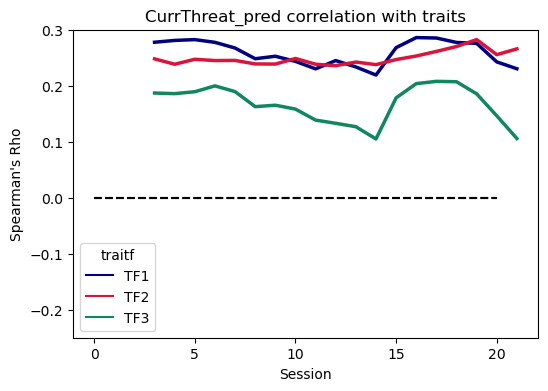

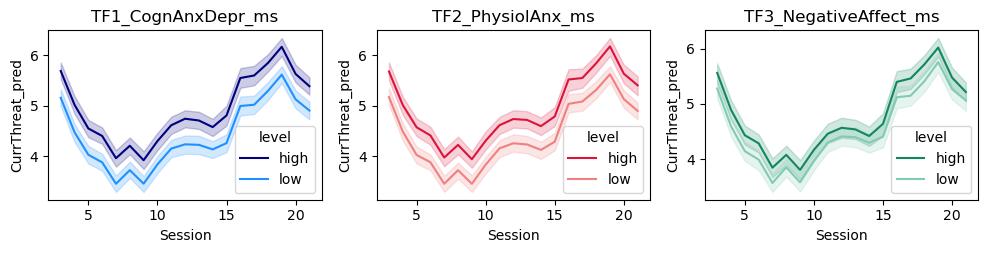

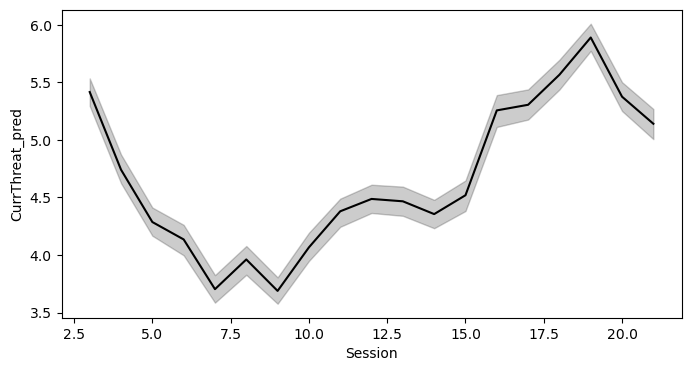

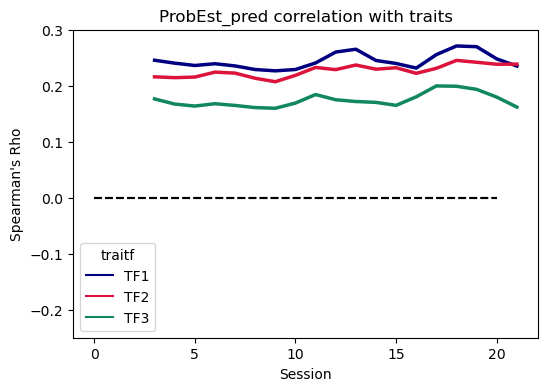

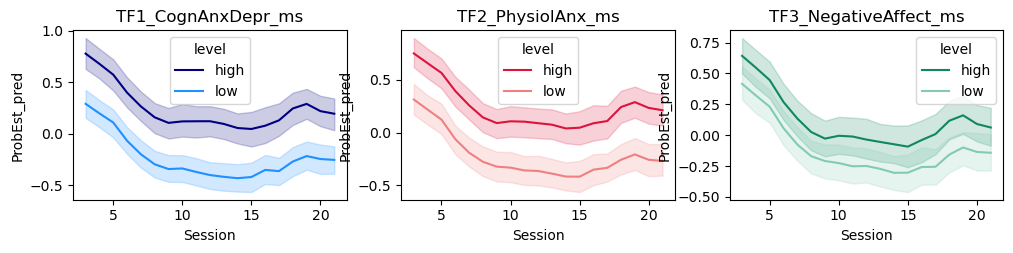

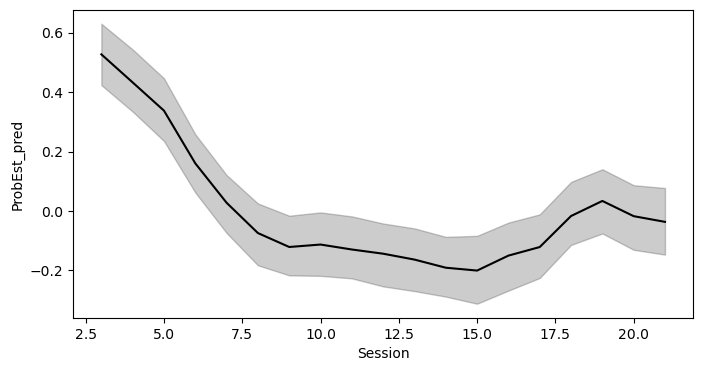

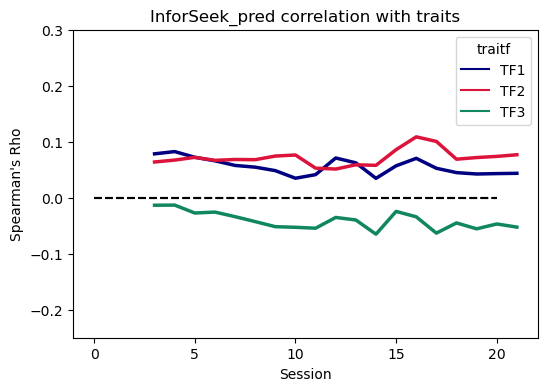

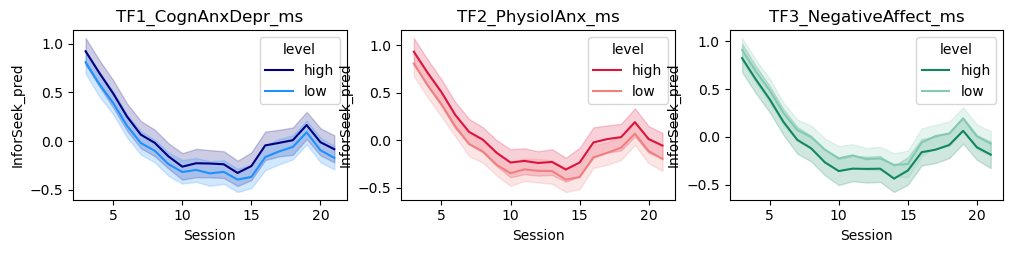

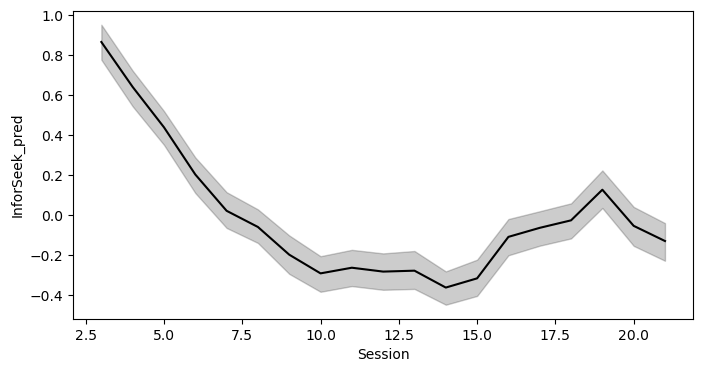

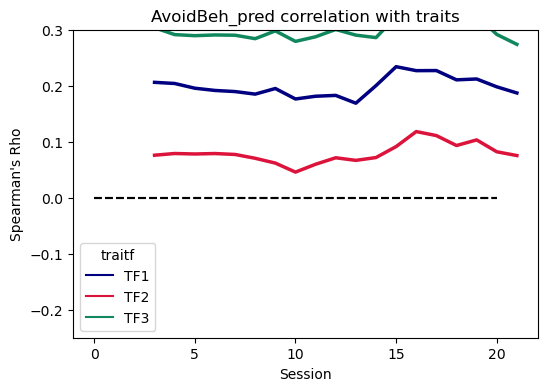

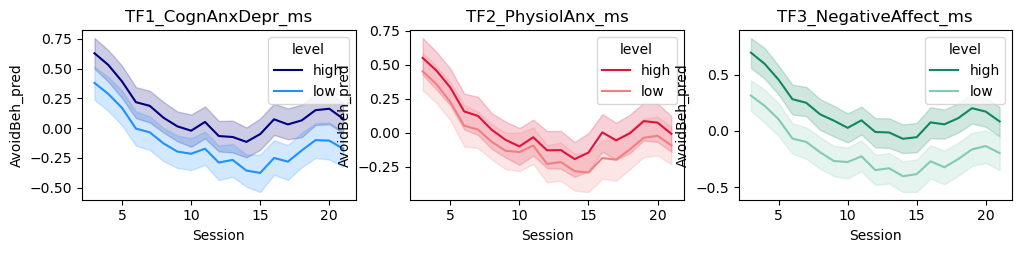

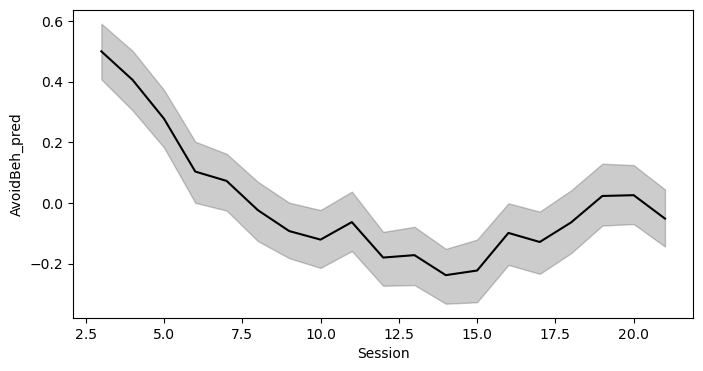

In [10]:
cordf
for v in cordf["index"].unique():
    print(v)
    td = cordf.loc[cordf["index"].isin([v]),:]
    td = td.melt(id_vars="Session", value_vars=tfs, var_name="traitf", value_name="corr" )

    f, ax = plt.subplots(1,1,figsize=(6,4))
    ax=sns.lineplot(data=td, x="Session", y="corr", hue="traitf", ax=ax, linewidth=2.5, palette=[colist[x][0] for x in range(3)])
    ax.set_title(v+ " correlation with traits")
    ax.set_ylabel("Spearman's Rho")

    ax.set_ylim([-0.25, 0.3])
    ax.hlines( [0, 0], 0, 20,linestyles='dashed', colors=['black'])

    f, ax = plt.subplots(1,len(tfs),figsize=(12,2.2))
    f.subplots_adjust(hspace=0.65)
    for t_idx, t in enumerate([x+"_ms" for x in trait_factor_names]): 
        tdf = tdata2.loc[tdata2["traitf"].isin([t]),:]
        axx=sns.lineplot(data=tdf, x="Session", y=v, hue="level", ax=ax[t_idx], palette=colist[t_idx])
        axx.set_title(t)

    #plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs',  'PUG_2024', v+'.pdf'), dpi=300, quality=80, optimize=True, progressive=True)  

    
    f,ax = plt.subplots(1,1, figsize=(8,4))
    ax = sns.lineplot(data=df2, x="Session", y=v, ax=ax, legend=True, color= "black")

## deaths with date labels